In [1]:
#%pip install qiskit qiskit_aer matplotlib pylatexenc

--- Sequential BV (measure-at-end) ---


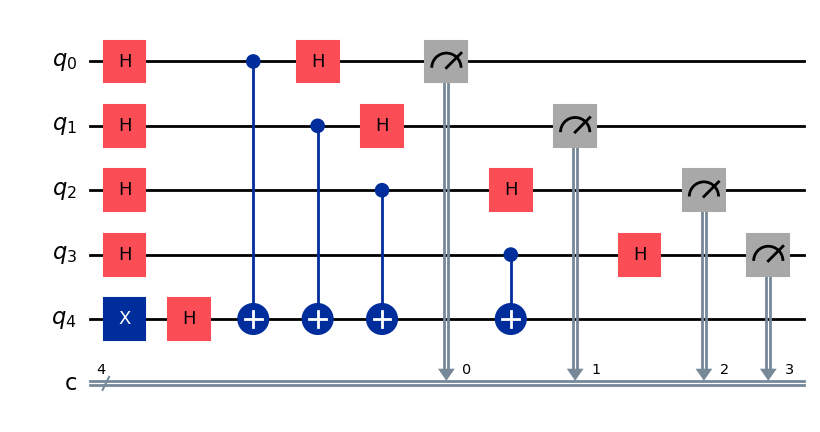

In [2]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode
import stim

s = '1111'
n = len(s)
qc_seq = QuantumCircuit(n + 1, n)

# Ancilla prep
qc_seq.x(n)
qc_seq.h(n)

for i in range(n):
    qc_seq.h(i)
    if s[n - 1 - i] == '1':
        qc_seq.cx(i, n)
    qc_seq.h(i)

for i in range(n):
    qc_seq.measure(i, i)

print("--- Sequential BV (measure-at-end) ---")
display(qc_seq.draw('mpl'))


Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

--- Optimized Circuit ---
Depth: 20
Qubits: 5
Reused 3 qubit(s)
Reuse chain: [(0, 1), (0, 2), (0, 3)]


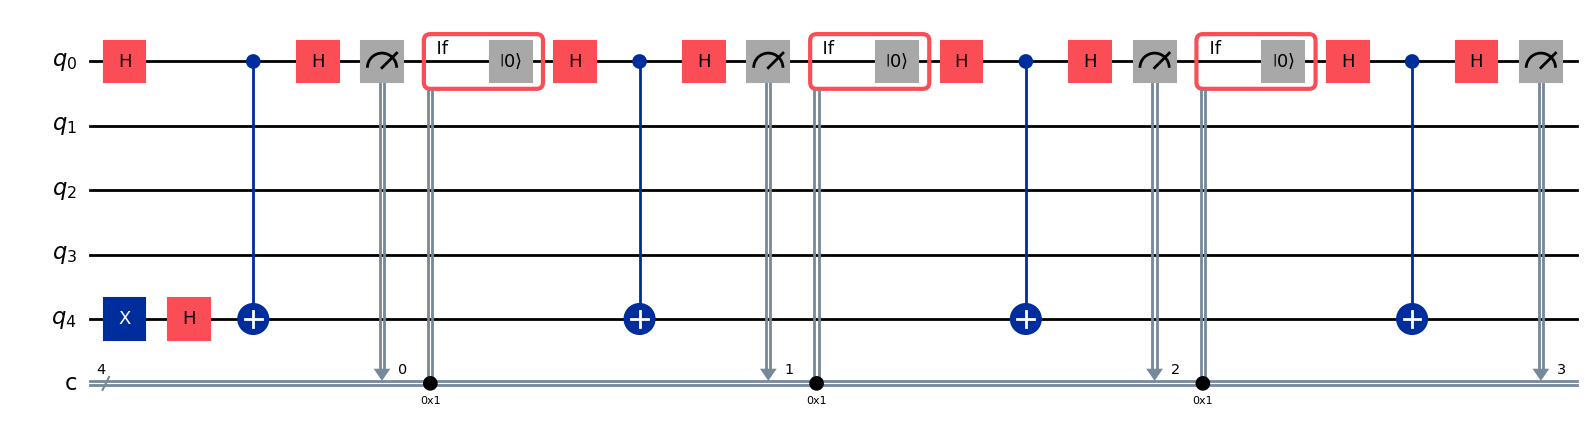

In [3]:
from circuit_analysis import find_qubit_reuse_pairs, modify_circuit, last_index_operation, first_index_operation
import sys

cur_qc = qc_seq.copy()
reuse_pairs = find_qubit_reuse_pairs(cur_qc)
print(f"\nInitial reusable pairs: {reuse_pairs}")
iter_count = 0
chain = []
weight = (1, 1, 1)


while len(reuse_pairs) > 0 and iter_count < len(qc_seq.qubits) - 1:
    depth_diff = sys.maxsize    
    lst_index = last_index_operation(cur_qc)
    fst_index = first_index_operation(cur_qc)
    
    for i in range(len(reuse_pairs)):
        test_qc = cur_qc.copy()
        test_out_qc = modify_circuit(test_qc, reuse_pairs[i])

        if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + weight[1]* lst_index[reuse_pairs[i][0]]+weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
            depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
            best_pair = reuse_pairs[i]

    # print(f"Best pair: {best_pair}")
    chain.append((best_pair[0], best_pair[1]))
    modified_qc = modify_circuit(cur_qc, best_pair)
    # print(modified_qc)

    reuse_pairs = find_qubit_reuse_pairs(modified_qc)
    cur_qc = modified_qc.copy()
    iter_count += 1
    lst_index = last_index_operation(cur_qc)

print(f"\n--- Optimized Circuit ---")
print(f"Depth: {cur_qc.depth()}")
print(f"Qubits: {cur_qc.num_qubits}")
print(f"Reused {iter_count} qubit(s)")
print(f"Reuse chain: {chain}")
display(cur_qc.draw('mpl'))

In [4]:
#print(cur_qc)
print(modified_qc)

     ┌───┐          ┌───┐┌─┐┌──────       ───────┐ ┌───┐     ┌───┐┌─┐┌────── »
q_0: ┤ H ├───────■──┤ H ├┤M├┤ If-0  ─|0>─  End-0 ├─┤ H ├──■──┤ H ├┤M├┤ If-0  »
     └───┘       │  └───┘└╥┘└──╥───       ───────┘ └───┘  │  └───┘└╥┘└──╥─── »
q_1: ────────────┼────────╫────╫──────────────────────────┼────────╫────╫────»
                 │        ║    ║                          │        ║    ║    »
q_2: ────────────┼────────╫────╫──────────────────────────┼────────╫────╫────»
                 │        ║    ║                          │        ║    ║    »
q_3: ────────────┼────────╫────╫──────────────────────────┼────────╫────╫────»
     ┌───┐┌───┐┌─┴─┐      ║    ║                        ┌─┴─┐      ║    ║    »
q_4: ┤ X ├┤ H ├┤ X ├──────╫────╫────────────────────────┤ X ├──────╫────╫────»
     └───┘└───┘└───┘      ║ ┌──╨──┐                     └───┘      ║ ┌──╨──┐ »
c: 4/═════════════════════╩═╡ 0x1 ╞════════════════════════════════╩═╡ 0x1 ╞═»
                          0 └─────┘                 

In [5]:
# #THIS IS SO COOKED: THE DOCUMENTATION VERSION IS NOT AVAILABLE TO INSTALL AND THE LATEST VERSION INTRODUCES THIS FUNCTION
# from mqt.qecc.circuit_synthesis.circuit_utils import 

# stim_circuit = (cur_qc)
# print(stim_circuit)

In [6]:
# #THIS IS ALSO GIGA COOKED: ERROR WITHIN THE LIBRARY
# from qiskit_qec.utils import get_stim_circuits


# test_qc_seq = QuantumCircuit(n + 1, n)
# test_qc_seq.h(n)

# for i in range(n):
#     test_qc_seq.h(i)
#     if s[n - 1 - i] == '1':
#         test_qc_seq.cx(i, n)
#     test_qc_seq.h(i)

# for i in range(n):
#     test_qc_seq.measure(i, i)

# print("--- Sequential BV (measure-at-end) ---")
# display(test_qc_seq.draw('mpl'))

# stim_circuit = get_stim_circuits(test_qc_seq)
# print(stim_circuit)

In [7]:
def qiskit_to_stim(qc):
    """
    Convert Qiskit circuit to Stim, handling if_else control flow.
    Flattens if_else blocks since Stim doesn't support classical conditionals.
    """
    stim_lines = []
    
    def process_instructions(instructions):
        """Recursively process instructions"""
        for inst, qargs, cargs in instructions:
            qubits = [qc.find_bit(q).index for q in qargs]
            
            if inst.name == 'h':
                stim_lines.append(f"H {' '.join(map(str, qubits))}")
            elif inst.name == 'x':
                stim_lines.append(f"X {' '.join(map(str, qubits))}")
            elif inst.name == 'cx':
                stim_lines.append(f"CNOT {qubits[0]} {qubits[1]}")
            elif inst.name == 'measure':
                stim_lines.append(f"M {' '.join(map(str, qubits))}")
            elif inst.name == 'reset':
                stim_lines.append(f"R {' '.join(map(str, qubits))}")
            elif inst.name == 'barrier':
                stim_lines.append(f"TICK")
            elif inst.name == 'if_else':
                # Extract and execute the true branch unconditionally
                # (Stim executes deterministically in noiseless mode)
                true_block = inst.params[0]
                if hasattr(true_block, 'data') and len(true_block.data) > 0:
                    process_instructions(true_block.data)
                # Note: false branch (if any) is ignored since we assume measurement was 1
            else:
                print(f"Warning: Unsupported operation '{inst.name}' skipped")
    
    process_instructions(qc.data)
    
    # Build Stim circuit
    stim_circuit = stim.Circuit()
    for line in stim_lines:
        stim_circuit.append_from_stim_program_text(line)
    
    return stim_circuit, stim_lines

# Convert to Stim
print("\n--- Converting to Stim ---")
stim_circuit, stim_text = qiskit_to_stim(cur_qc)

# Save to .stim file
stim_filename = 'caqr_optimized_circuit.stim'
with open(stim_filename, 'w') as f:
    f.write('\n'.join(stim_text))

print(f"Exported to {stim_filename}")
print(f"Total instructions: {len(stim_text)}")
print("\nFirst 20 lines:")
print('\n'.join(stim_text[:20]))

print(f"\n--- Stim Circuit ---")
print(stim_circuit)


--- Converting to Stim ---
Exported to caqr_optimized_circuit.stim
Total instructions: 21

First 20 lines:
X 4
H 4
H 0
CNOT 0 4
H 0
M 0
R 0
H 0
CNOT 0 4
H 0
M 0
R 0
H 0
CNOT 0 4
H 0
M 0
R 0
H 0
CNOT 0 4
H 0

--- Stim Circuit ---
X 4
H 4 0
CX 0 4
H 0
M 0
R 0
H 0
CX 0 4
H 0
M 0
R 0
H 0
CX 0 4
H 0
M 0
R 0
H 0
CX 0 4
H 0
M 0


C:\Users\yasit\AppData\Local\Temp\ipykernel_17816\1263325018.py:10: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in instructions:


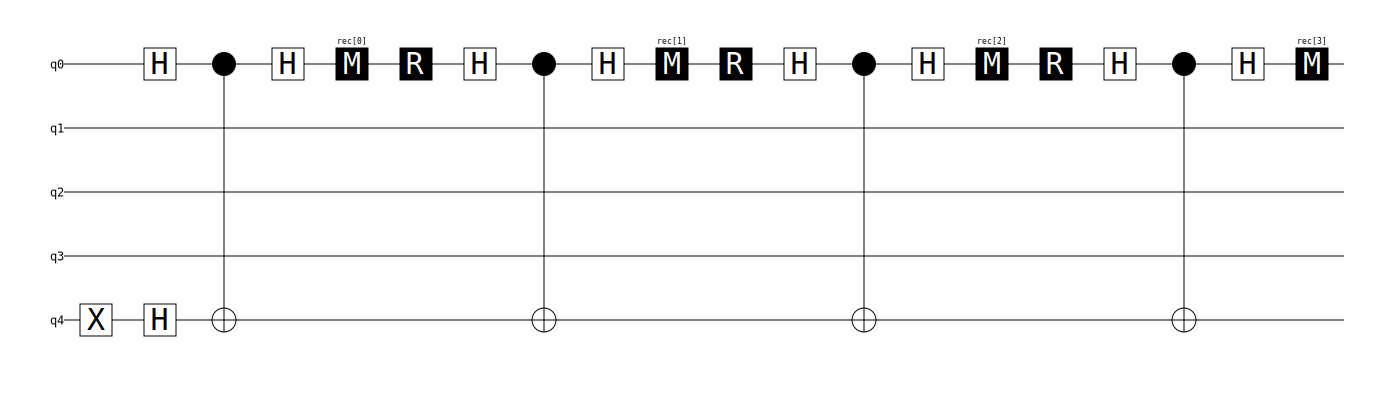

In [10]:
stim_circuit.diagram("timeline-svg")

In [9]:
import stim

circuit = stim.Circuit()

circuit.append("X", [4])
circuit.append("H", [0, 1, 2, 3, 4])
circuit.append("CNOT", [0, 4])
circuit.append("H", [0])
circuit.append("CNOT", [1, 4])
circuit.append("H", [1])
circuit.append("CNOT", [2, 4])
circuit.append("H", [2])
circuit.append("CNOT", [3, 4])
circuit.append("H", [3])
circuit.append("M", [0, 1, 2, 3])
# circuit.append("H", [0])
# circuit.append("CNOT", [0, 1])

# # Then, the circuit will measure both qubits of the Bell pair in the Z basis.
# circuit.append("M", [0, 1])


circuit.diagram()

q0: -H---@-H-----M:rec[0]----------
         |
q1: -H---|-@-H---M:rec[1]----------
         | |
q2: -H---|-|-@-H-M:rec[2]----------
         | | |
q3: -H---|-|-|-@-H--------M:rec[3]-
         | | | |
q4: -X-H-X-X-X-X-------------------